In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/train.csv") # Display the first few rows to verify successful loading
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.shape

(159571, 8)

In [4]:
df["label"] = ( # If any toxic category is present, the comment is labeled as toxic (1)
    df["toxic"] |
    df["severe_toxic"] |
    df["obscene"] |
    df["threat"] |
    df["insult"] |
    df["identity_hate"]
)

In [5]:
df["label"].value_counts() # Check the distribution of toxic vs non-toxic comments

label
0    143346
1     16225
Name: count, dtype: int64

In [6]:
df[["comment_text", "label"]].head() #to check which ones has toxic comment

,comment_text,label
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
import re
import nltk
from nltk.corpus import stopwords

In [8]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GIGABYTE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words("english"))

def clean_text(text): # Function to clean and normalize text data
    text = text.lower()                      # lowercase
    text = re.sub(r"http\S+", "", text)      # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)     # remove punctuation & numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    return " ".join(words)

In [10]:
df["clean_text"] = df["comment_text"].apply(clean_text) # Apply the cleaning function to all comments
df[["comment_text", "clean_text"]].head() # Compare original and cleaned text

,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page thats


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df["clean_text"] # X contains the cleaned text (features)
y = df["label"] # y contains the binary toxicity labels

In [13]:
X_train, X_test, y_train, y_test = train_test_split( # Split the data: 80% training, 20% testing
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [14]:
print(len(X_train), len(X_test)) #quick check

127656 31915


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
vectorizer = TfidfVectorizer(
    max_features=10000, # max_features limits the vocabulary size to the most important words
    ngram_range=(1, 2)
) 

In [17]:
X_train_tfidf = vectorizer.fit_transform(X_train) # Fit the vectorizer on training data and transform text into numerical features

In [18]:
X_test_tfidf = vectorizer.transform(X_test) # Transform test data using the same vectorizer

In [19]:
X_train_tfidf.shape #check if tfidf works

(127656, 10000)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [21]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(
    max_iter=1000, # max_iter is increased to ensure convergence
    class_weight="balanced"
) 

lr_model.fit(X_train_tfidf, y_train) # Train the model using TF-IDF features

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [22]:
nb_model = MultinomialNB() # Initialize Naive Bayes model

nb_model.fit(X_train_tfidf, y_train) # Train the Naive Bayes model

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [23]:
from sklearn.metrics import accuracy_score, classification_report

In [24]:
lr_preds = lr_model.predict(X_test_tfidf) # Make predictions on test data

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds)) # Print accuracy and detailed metrics
print(classification_report(y_test, lr_preds))

Logistic Regression Accuracy: 0.9283722387592042
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     28671
           1       0.61      0.85      0.71      3244

    accuracy                           0.93     31915
   macro avg       0.79      0.89      0.83     31915
weighted avg       0.94      0.93      0.93     31915



In [25]:
nb_preds = nb_model.predict(X_test_tfidf) # Make predictions on test data

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_preds)) # Print accuracy and detailed metrics
print(classification_report(y_test, nb_preds))

Naive Bayes Accuracy: 0.9481435061883127
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28671
           1       0.93      0.53      0.68      3244

    accuracy                           0.95     31915
   macro avg       0.94      0.76      0.82     31915
weighted avg       0.95      0.95      0.94     31915



In [26]:
# Select the best-performing model
best_model = lr_model

In [27]:
import pickle

In [28]:
# Save the trained model to the models folder
with open("../models/model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [29]:
# Save the TF-IDF vectorizer
with open("../models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [30]:
# cross_val_score is used to evaluate a model using cross-validation
from sklearn.model_selection import cross_val_score

In [31]:
# Use the entire cleaned dataset for cross-validation
X_all = df["clean_text"] # X_all contains the cleaned text comments
y_all = df["label"] # y_all contains the binary toxicity labels

In [32]:
# Pipeline ensures that TF-IDF vectorization and model training
# are performed correctly within each cross-validation fold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
# Create a pipeline that:
lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)), # 1. Converts text into numerical features using TF-IDF
    ("classifier", LogisticRegression(max_iter=1000)) # 2. Trains a Logistic Regression classifier
])

In [34]:
# Perform 5-fold cross-validation
# The model is trained and evaluated 5 times
# Each fold uses a different subset of data for validation
cv_scores = cross_val_score(
    lr_pipeline,   # pipeline containing TF-IDF + classifier
    X_all,         # input text data
    y_all,         # target labels
    cv=5,          # number of folds
    scoring="accuracy"  # evaluation metric
)

In [35]:
# Display accuracy score for each fold
print("Cross-validation accuracy scores:", cv_scores)

# Display the average accuracy across all folds
print("Mean cross-validation accuracy:", cv_scores.mean())

Cross-validation accuracy scores: [0.95585148 0.95581876 0.95547409 0.9558501  0.95578743]
Mean cross-validation accuracy: 0.9557563711757819


In [36]:
from sklearn.metrics import f1_score, roc_auc_score

# F1 score for toxic class
f1 = f1_score(y_test, lr_preds)
roc = roc_auc_score(y_test, lr_model.predict_proba(X_test_tfidf)[:, 1])

print("F1 Score:", f1)
print("ROC AUC:", roc)

F1 Score: 0.7068479097204411
ROC AUC: 0.9640542805425435


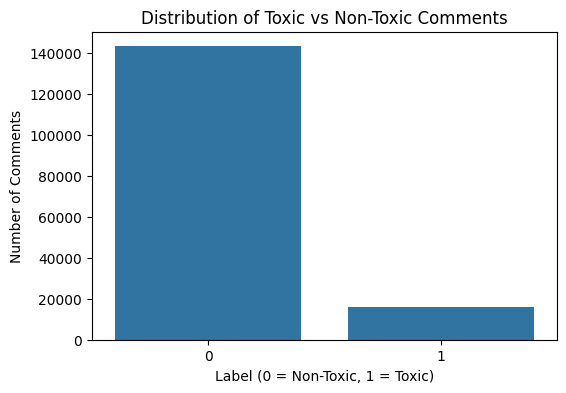

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of toxic vs non-toxic comments
plt.figure(figsize=(6,4))
sns.countplot(x=df["label"])
plt.title("Distribution of Toxic vs Non-Toxic Comments")
plt.xlabel("Label (0 = Non-Toxic, 1 = Toxic)")
plt.ylabel("Number of Comments")
plt.show()

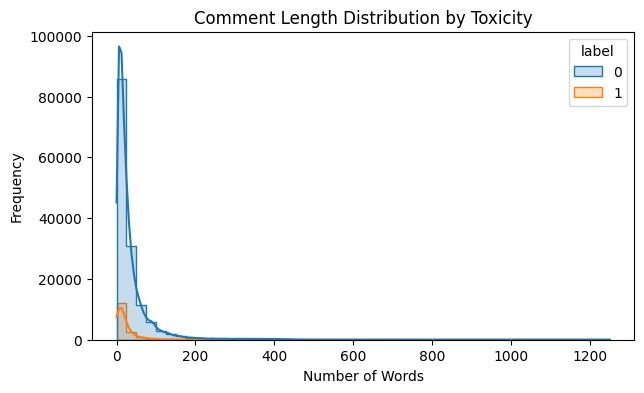

In [38]:
# Calculate comment lengths
df["comment_length"] = df["clean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,4))
sns.histplot(
    data=df,
    x="comment_length",
    hue="label",
    bins=50,
    kde=True,
    element="step"
)
plt.title("Comment Length Distribution by Toxicity")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

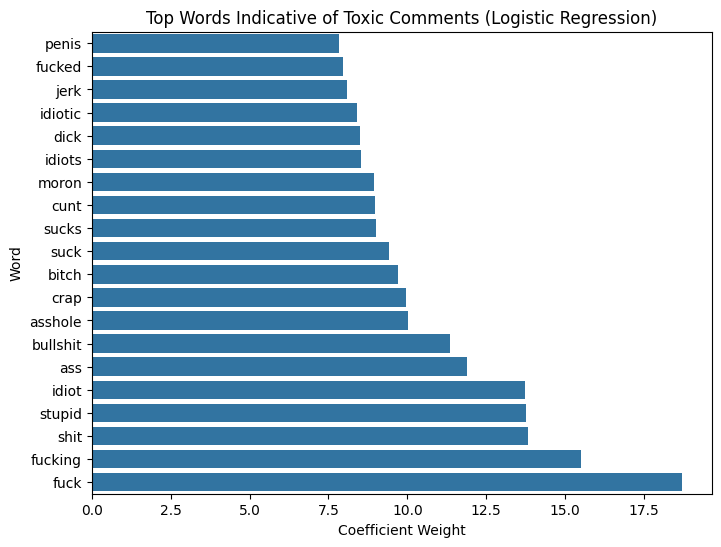

In [39]:
import numpy as np

# Get feature names from TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Get coefficients from Logistic Regression
coefficients = best_model.coef_[0]

# Get top positive coefficients (toxic indicators)
top_toxic_indices = np.argsort(coefficients)[-20:]

top_toxic_words = feature_names[top_toxic_indices]
top_toxic_scores = coefficients[top_toxic_indices]

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=top_toxic_scores, y=top_toxic_words)
plt.title("Top Words Indicative of Toxic Comments (Logistic Regression)")
plt.xlabel("Coefficient Weight")
plt.ylabel("Word")
plt.show()

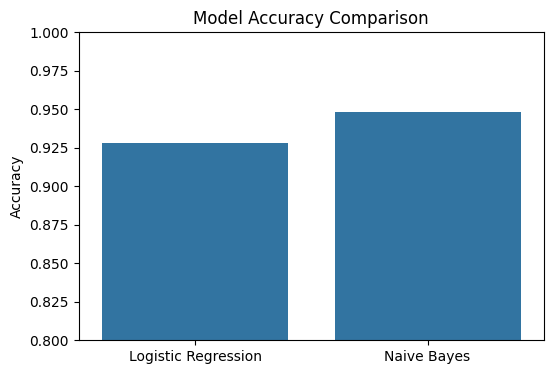

In [40]:
# Store accuracy results
models = ["Logistic Regression", "Naive Bayes"]
accuracies = [
    accuracy_score(y_test, lr_preds),
    accuracy_score(y_test, nb_preds)
]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.show()